In [18]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

## ✂️ Step 1 - Load and Filter the Dataset

- Based on previous analysis, **fraud only occurs in `TRANSFER` and `CASH_OUT`** transactions.
- Other types like `PAYMENT`, `CASH_IN`, and `DEBIT` can safely be removed to reduce noise and focus the model.
- This filtering step significantly reduces the dataset size, while preserving 100% of the fraud cases.

In [5]:
# Load the PaySim dataset
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
print(f'Data Imported Successfully! Shape: {df.shape[0]:,} rows × {df.shape[1]} columns')

Data Imported Successfully! Shape: 6,362,620 rows × 11 columns


In [6]:
# Keep only transaction types where fraud actually occurs
# According to the EDA, fraud is only found in TRANSFER and CASH_OUT transactions
df_filtered = df.loc[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()

# Reset index after filtering for a clean dataset
df_filtered.reset_index(drop=True, inplace=True)

# Drop irrelevant columns
df_filtered.drop(columns=['nameOrig','nameDest','isFlaggedFraud'], inplace=True)

# Encode type as binary
df_filtered['type'] = df_filtered['type'].map({'TRANSFER':0, 'CASH_OUT':1}).astype(int)

# 🔢 Print shape to confirm reduction in data
print(f"Filtered dataset shape: {df_filtered.shape[0]:,} rows × {df_filtered.shape[1]} columns")


Filtered dataset shape: 2,770,409 rows × 8 columns


## 🛠️ Step 2 – Feature Engineering: New Variables for Fraud Detection

In [7]:
# A. 🧮 Balance Error Features
# Logical inconsistencies: expected post-transaction balances should match actual values
df_filtered['errorBalanceOrig'] = df_filtered['newbalanceOrig'] + df_filtered['amount'] - df_filtered['oldbalanceOrg']
df_filtered['errorBalanceDest'] = df_filtered['oldbalanceDest'] + df_filtered['amount'] - df_filtered['newbalanceDest']

# B. 🟦 Binary Flags: Zero Balances
# Flags to capture accounts that have no funds before/after the transaction
df_filtered['orig_balance_zero_before'] = (df_filtered['oldbalanceOrg'] == 0).astype(int)
df_filtered['orig_balance_zero_after']  = (df_filtered['newbalanceOrig'] == 0).astype(int)
df_filtered['dest_balance_zero_before'] = (df_filtered['oldbalanceDest'] == 0).astype(int)
df_filtered['dest_balance_zero_after']  = (df_filtered['newbalanceDest'] == 0).astype(int)

# C. ⚠️ Flag: Did the origin account get completely emptied?
df_filtered['is_orig_emptied'] = ((df_filtered['newbalanceOrig'] == 0) & (df_filtered['amount'] > 0)).astype(int)

# D. 📊 Proportional Feature: Transaction amount vs origin balance
df_filtered['amount_to_balance_ratio'] = df_filtered['amount'] / (df_filtered['oldbalanceOrg'] + 1)  # Avoid division by zero

# E. 🔄 Encoded Transaction Type
# Binary encoding: 1 if CASH_OUT, 0 if TRANSFER
df_filtered['is_cash_out'] = (df_filtered['type'] == 'CASH_OUT').astype(int)
# Alternatively, you can use one-hot encoding if both types need to be modeled separately

# F. 📈 Outlier Detection: Z-score on amount
df_filtered['amount_zscore'] = zscore(df_filtered['amount'])
df_filtered['amount_outlier'] = (abs(df_filtered['amount_zscore']) > 3).astype(int)

# ✅ Preview new features
df_filtered.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,orig_balance_zero_before,orig_balance_zero_after,dest_balance_zero_before,dest_balance_zero_after,is_orig_emptied,amount_to_balance_ratio,is_cash_out,amount_zscore,amount_outlier
0,1,0,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,0,1,1,1,1,0.994505,0,-0.357467,0
1,1,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,0,1,0,1,1,0.994505,0,-0.357467,0
2,1,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,0,1,0,0,1,14.950668,0,-0.099576,0
3,1,0,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,0,1,0,1,1,304.972096,0,-0.115146,0
4,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,0,1,0,0,1,28.763925,0,-0.006590,0


#### ✅ New Features Summary:
- **Balance errors** help detect logical inconsistencies that may indicate fraudulent simulation.
- **Zero-balance flags** identify abnormal behavior in account status before/after transactions.
- **Proportional amount ratio** detects unusually large transactions relative to the sender’s funds.
- **Z-score outlier flag** marks exceptionally large transfers that deviate from the normal distribution.
- **Binary transaction type** simplifies modeling by focusing on fraud-prone categories.

These engineered features are designed to enhance the model’s ability to detect subtle fraud patterns.

## 📦 Step 3 - Dataset Preparation: Feature Selection for Modeling

In [8]:
# Variables predictoras (X) y variable objetivo (Y)
target = 'isFraud'

# Variables a excluir
excluded = ['nameOrig', 'nameDest', 'type', 'isFlaggedFraud', 'step', 'amount_zscore']

# Features numéricas y derivadas
features = [col for col in df_filtered.columns if col not in excluded + [target]]

X = df_filtered[features]
y = df_filtered[target]

#### ✅ Dataset Preparation Summary:
- We exclude identifiers and redundant columns that do not contribute to prediction.
- The remaining features include:
  - Engineered variables (balance errors, ratios, flags)
  - Cleaned and filtered transaction data
- `X` contains the predictors, while `y` contains the binary fraud label (`isFraud`).

## 📊 Step 4 - Data Visualization Checkpoint: Is the Problem Learnable?

To confirm that machine learning can make strong predictions on this dataset, we explore several visual perspectives:

- **Temporal distribution** of fraud vs. genuine transactions.
- **Transaction amount patterns**, including outliers.
- **Balance inconsistency analysis**, particularly `errorBalanceDest`.
- **Comparative feature distributions** that show how fraud differs from normal behavior.
- **Class separability fingerprints** using KDEs, scatterplots, and PCA.

These insights will serve as evidence that our data is not only clean, but also **informative**, and supports **discriminative modeling**.

### Distribution Over Time


/var/folders/zf/wj_jktvx4jb2w0ylv97cdxyh0000gn/T/ipykernel_7602/2598250857.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


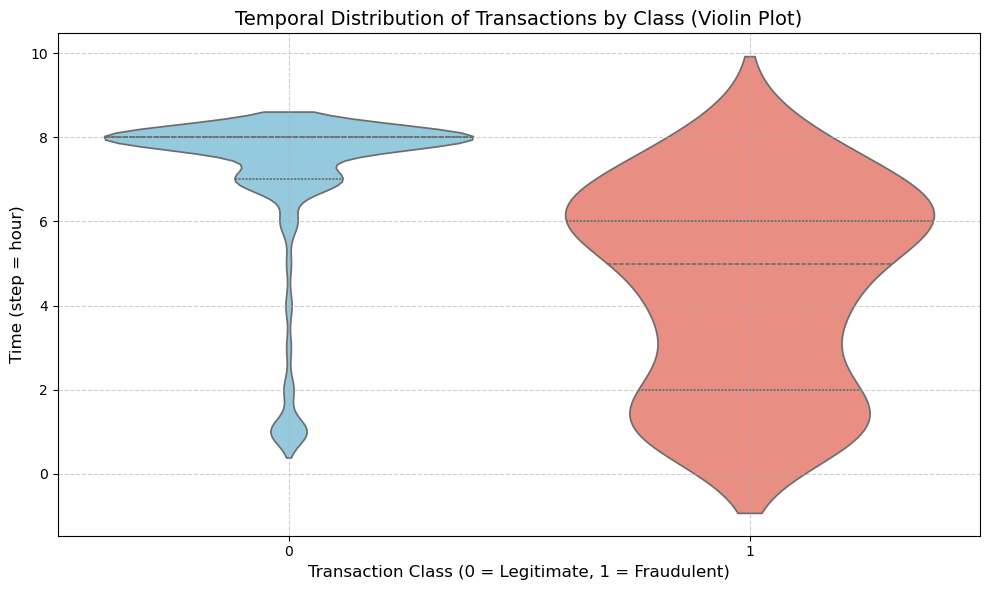

In [9]:
# Limit number of samples for visual clarity
limit = 10000
subset = df_filtered[:limit]

plt.figure(figsize=(10, 6))
sns.violinplot(
    x='isFraud',
    y='step',
    hue='isFraud',                 
    data=subset,
    palette={0: "skyblue", 1: "salmon"},
    scale='width',
    inner='quartile',
    legend=False                   
)

plt.title("Temporal Distribution of Transactions by Class (Violin Plot)", fontsize=14)
plt.xlabel("Transaction Class (0 = Legitimate, 1 = Fraudulent)", fontsize=12)
plt.ylabel("Time (step = hour)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 💸 Dispersion of errorBalanceDest – Fraud vs. Legitimate


/var/folders/zf/wj_jktvx4jb2w0ylv97cdxyh0000gn/T/ipykernel_7602/178172219.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


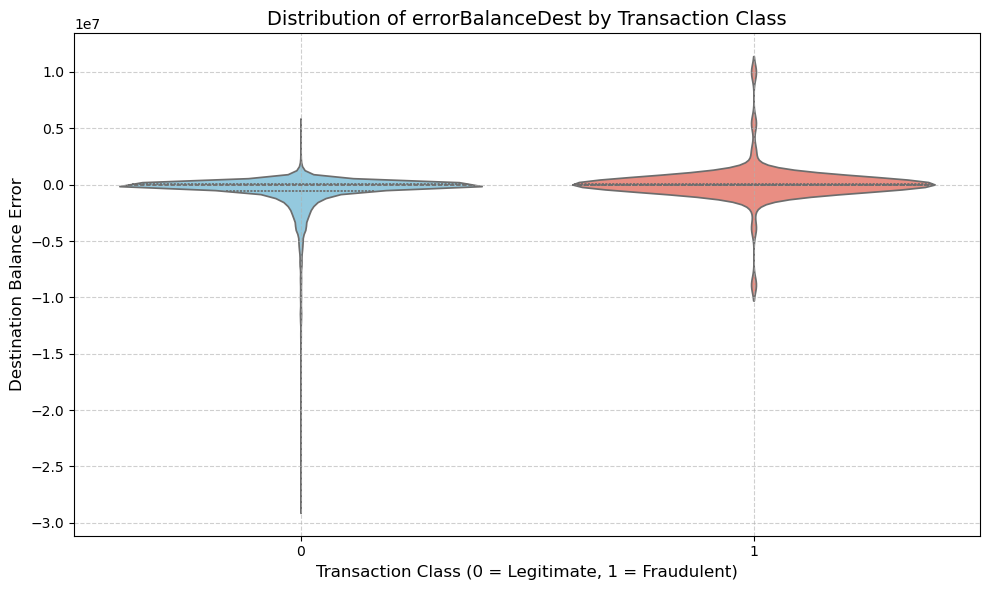

In [10]:
# Limit the data for better visualization
limit = 10000
subset = df_filtered[:limit]

plt.figure(figsize=(10, 6))
sns.violinplot(
    x='isFraud',
    y='errorBalanceDest',
    hue='isFraud',
    data=subset,
    palette={0: 'skyblue', 1: 'salmon'},
    scale='width',
    inner='quartile',
    legend=False
)

plt.title("Distribution of errorBalanceDest by Transaction Class", fontsize=14)
plt.xlabel("Transaction Class (0 = Legitimate, 1 = Fraudulent)", fontsize=12)
plt.ylabel("Destination Balance Error", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 🔮 3D PCA – Class Separation: Fraud vs Legitimate

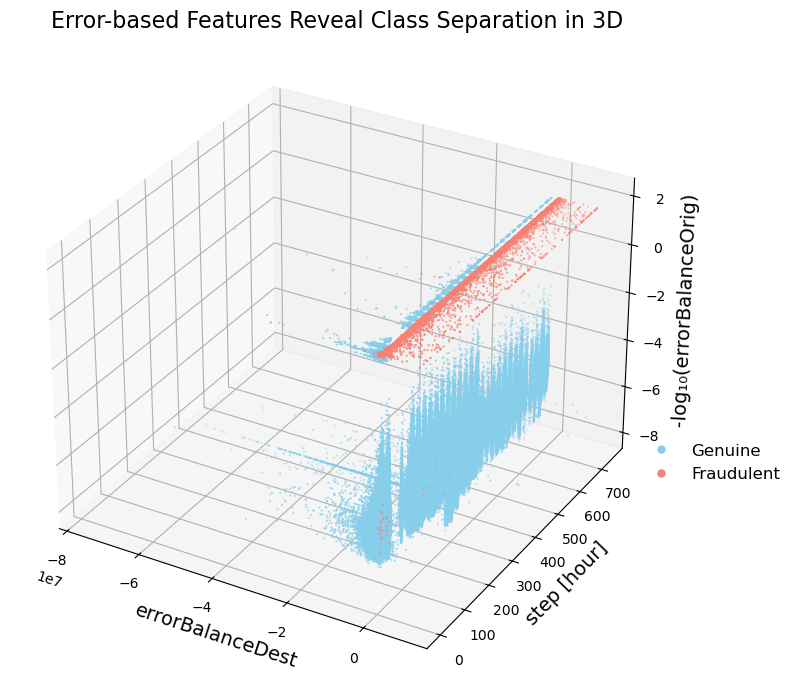

In [11]:
# 🧪 Choose three engineered features
x = 'errorBalanceDest'
y = 'step'
z = 'errorBalanceOrig'
zOffset = 0.02  # to avoid log(0)
limit = len(df_filtered)   # adjust for performance

# ✅ Reset Seaborn defaults to allow 3D plotting
sns.reset_orig()

fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d')

# 💚 Plot genuine transactions
ax.scatter(
    df_filtered.loc[df_filtered['isFraud'] == 0, x][:limit],
    df_filtered.loc[df_filtered['isFraud'] == 0, y][:limit],
    -np.log10(df_filtered.loc[df_filtered['isFraud'] == 0, z][:limit] + zOffset),
    c='skyblue', marker='.', s=1, label='Genuine'
)

# ❤️ Plot fraudulent transactions
ax.scatter(
    df_filtered.loc[df_filtered['isFraud'] == 1, x][:limit],
    df_filtered.loc[df_filtered['isFraud'] == 1, y][:limit],
    -np.log10(df_filtered.loc[df_filtered['isFraud'] == 1, z][:limit] + zOffset),
    c='salmon', marker='.', s=1, label='Fraudulent'
)

# 🏷️ Axis labels
ax.set_xlabel(f'{x}', fontsize=14)
ax.set_ylabel(f'{y} [hour]', fontsize=14)
ax.set_zlabel(f'-log₁₀({z})', fontsize=14)
ax.set_title("Error-based Features Reveal Class Separation in 3D", fontsize=16)

# 🎯 Custom legend
noFraudMarker = mlines.Line2D([], [], linewidth=0, color='skyblue', marker='.', markersize=10, label='Genuine')
fraudMarker   = mlines.Line2D([], [], linewidth=0, color='salmon', marker='.', markersize=10, label='Fraudulent')

plt.legend(handles=[noFraudMarker, fraudMarker], bbox_to_anchor=(1.20, 0.4), frameon=False, prop={'size': 12})
ax.grid(True)
plt.tight_layout()
plt.show()

### 🔥 Fingerprint Heatmaps – Feature Correlation in Genuine vs Fraudulent Transactions

/var/folders/zf/wj_jktvx4jb2w0ylv97cdxyh0000gn/T/ipykernel_7602/3854464508.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/opt/homebrew/Caskroom/miniconda/base/envs/stats_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


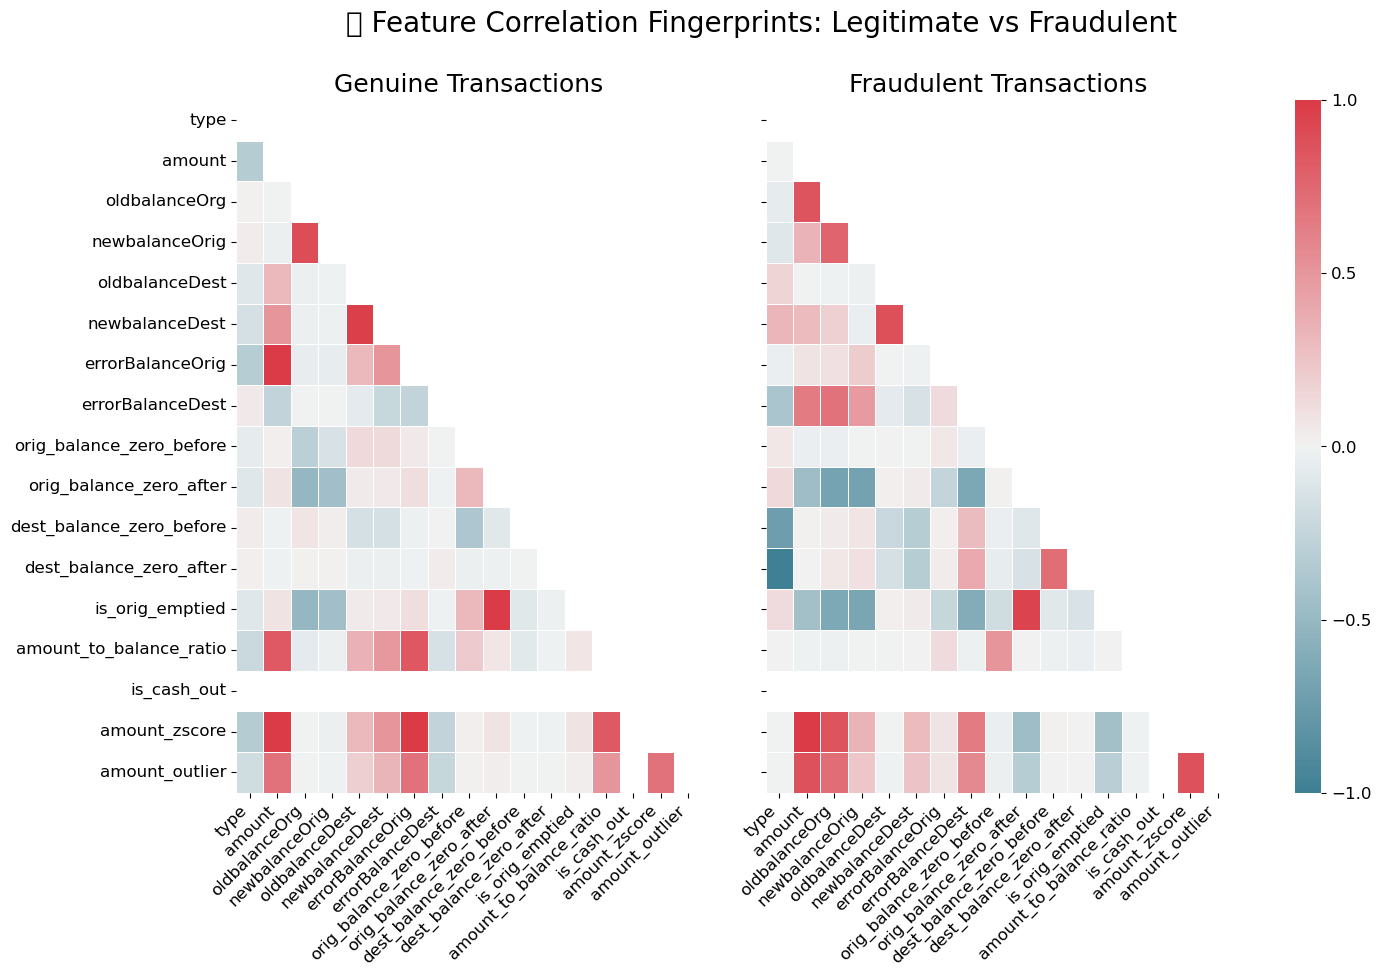

In [ ]:

# 💡 Preserve the target before modifying X
Y = df_filtered['isFraud']
X = df_filtered.drop(columns=['isFraud'])

# ⚖️ Separate data by class for fingerprinting
X_fraud = X[Y == 1]
X_legit = X[Y == 0]

# 📈 Correlation matrices (excluding 'step')
corr_legit = X_legit.drop(columns=['step']).corr()
corr_fraud = X_fraud.drop(columns=['step']).corr()

# 🔲 Mask upper triangle for symmetry
mask = np.triu(np.ones_like(corr_legit, dtype=bool))

# 🔥 Setup side-by-side heatmaps
grid_kws = {"width_ratios": (.9, .9, .05), "wspace": 0.2}
fig, (ax1, ax2, cbar_ax) = plt.subplots(1, 3, figsize=(14, 9), gridspec_kw=grid_kws)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# 🟦 Genuine transactions
sns.heatmap(
    corr_legit,
    ax=ax1,
    mask=mask,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    square=False,
    linewidths=0.5,
    cbar=False
)
ax1.set_title('Genuine Transactions', fontsize=18)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)

# 🔴 Fraudulent transactions
sns.heatmap(
    corr_fraud,
    ax=ax2,
    mask=mask,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    square=False,
    linewidths=0.5,
    cbar_ax=cbar_ax,
    cbar_kws={'orientation': 'vertical', 'ticks': [-1, -0.5, 0, 0.5, 1]}
)
ax2.set_title('Fraudulent Transactions', fontsize=18)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=12)
ax2.set_yticklabels([])  # hide y labels on second plot

cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize=12)

plt.suptitle("🔍 Feature Correlation Fingerprints: Legitimate vs Fraudulent", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## ⚖️ Step 5 - Class Imbalance Handling

In [ ]:
# Variables predictoras (X) y variable objetivo (Y)
target = 'isFraud'

# Variables a excluir
excluded = ['nameOrig', 'nameDest', 'type', 'isFlaggedFraud', 'step', 'amount_zscore']

# Features numéricas y derivadas
features = [col for col in df_filtered.columns if col not in excluded + [target]]

X = df_filtered[features]
y = df_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

## 🏋🏻‍♀️ Step 6 - Model Training

In [20]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest (Balanced)': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost (Weighted)': XGBClassifier(scale_pos_weight=np.round((y_train == 0).sum() / (y_train == 1).sum(), 2), use_label_encoder=False, eval_metric='logloss')
}

# Train and store each model on resampled data
for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    print(f"✅ Trained: {name}")

✅ Trained: Logistic Regression
✅ Trained: Random Forest (Balanced)


/opt/homebrew/Caskroom/miniconda/base/envs/stats_env/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [17:09:41] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Trained: XGBoost (Weighted)


## 📏 Step 7 - Basic Evaluations

In [21]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n📊 {name}")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")


📊 Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    828659
           1       0.04      0.96      0.08      2464

    accuracy                           0.94    831123
   macro avg       0.52      0.95      0.52    831123
weighted avg       1.00      0.94      0.96    831123

ROC AUC: 0.9878

📊 Random Forest (Balanced)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.96      1.00      0.98      2464

    accuracy                           1.00    831123
   macro avg       0.98      1.00      0.99    831123
weighted avg       1.00      1.00      1.00    831123

ROC AUC: 0.9987

📊 XGBoost (Weighted)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.92      1.00      0.96      2464

    accuracy                           1.00    831123
   macro avg       0.96